In [4]:
#!pip install torch numpy matplotlib seaborn

In [1]:
"""
如何看代码
1 句子token
2 token后embedding
3 
"""

'\n如何看代码\n1 句子token\n2 token后embedding\n3 \n'

In [2]:
import math,torch
import torch.nn as nn
from torch.autograd import Variable #变量封装函数

In [ ]:
#数据token后，进行embedding
class Embedding(nn.Module):
    def __init__(self, d_model,vocab):
        super(Embedding,self).__init__()
        self.lut=nn.Embedding(vocab,d_model)
        self.d_model=d_model
    def forward(self,x):
        return self.lut(x)*math.sqrt(self.d_model)
'''
embedding = Embedding(10,30)
input=torch.tensor([[1,2,4,5],[5,2,5,6]],dtype=torch.long)
embedding(input)
'''

#position emb
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        super(PositionalEncoding,self).__init__()

'\nembedding = Embedding(10,30)\ninput=torch.tensor([[1,2,4,5],[5,2,5,6]],dtype=torch.long)\nembedding(input)\n'

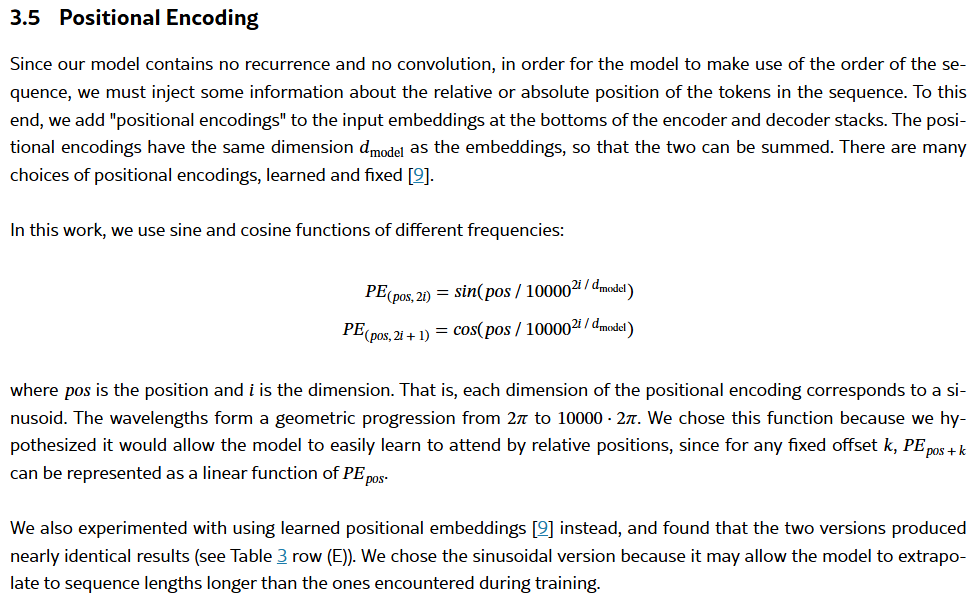